# BRAIN TUMOURS 
### AANN PROJECT 2025
Grzegorz Olszak 


I found this project on kaggle and I mentioned it in the mail concerning the project [Link](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data)

I have downloaded the data using "script" in the file `download_data.py` and moved it to the `data/` directory 

Structure of the project is in the markdown cell below

In `src` directory I placed the code for the custom dataset (`loading_data.py`), model (`model.py`), training, validation and testing (`processes.py`) 

For me it increased the readability of the code. I hope it is not a problem. I thought that it might be easy to read through it this way with verification of the code in apropriate file 

Commentary to the project, except markdown cells, is within the code in the form of comments  

```plaintext
├── analyze.ipynb
├── data
│   ├── Testing
│   │   ├── glioma_tumor
│   │   ├── meningioma_tumor
│   │   ├── no_tumor
│   │   └── pituitary_tumor
│   └── Training
│       ├── glioma_tumor
│       ├── meningioma_tumor
│       ├── no_tumor
│       └── pituitary_tumor
├── download_data.py
├── requirements.txt
└── src
    ├── __pycache__
    │   ├── data_loading.cpython-313.pyc
    │   ├── models.cpython-313.pyc
    │   └── processes.cpython-313.pyc
    ├── data_loading.py
    ├── models.py
    └── processes.py


There are also comments to the code in the files containg classes used in the analysis

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from src.data_loading import CustomDataset

# deafult transform of pictures is implemented in the CustomDataset class
# i decided to transform it from RGB to grayscale as 
# as i thought it would be easier to train the model and did not see connection between color MRI
# but this might have been a mistake

# CustomDataset is build on top datasets.ImageFolder class which was really helpful
brain_tumor_dataset = CustomDataset()

train_dataset = brain_tumor_dataset.data_train
test_dataset = brain_tumor_dataset.data_test

# I created the loaders for the training, validation with stratification of classes
train_loader, validate_loader = brain_tumor_dataset.get_train_loader()
test_loader = brain_tumor_dataset.get_test_loader()

print("Classes:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)

# One batch to see the output shapes.
for images, labels in train_loader:
    print("Image batch shape:", images.size())  
    print("Labels batch shape:", labels.size())   


Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class to index mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Image batch shape: torch.Size([32, 1, 224, 224])
Labels batch shape: torch.Size([32])


[ 1  6 14 29 19]


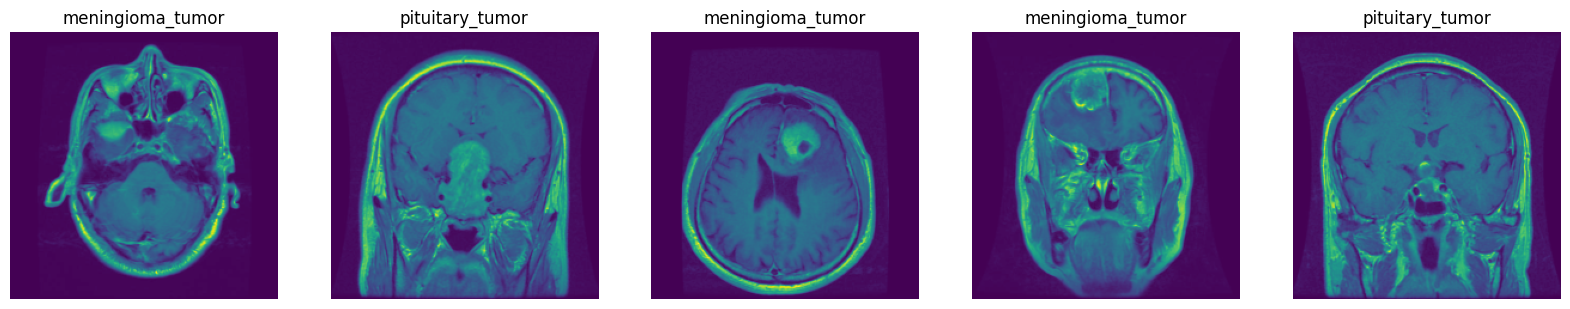

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_example(images, labels, class_map=None):

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    images_numbers = np.random.choice(np.arange(0, images.shape[0], 1), 5, replace=False)
    print(images_numbers)
    for i, img_n in enumerate(images_numbers):
        axs[i].imshow(images[img_n].permute(1, 2, 0))
        if class_map: 
            title = class_map[labels[img_n].item()]
        else:
            title = labels[i].item()
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}    


plot_example(images, labels, class_map=idx_to_class)

# Simplest case

I decided to use the simplest model as I ran it without CUDA locally (1) 
and also thought that just using more complex or pretrained model is not so complicated (2)
Probably I was wrong but tried to squeez what I could with this primitive one

In [ ]:
import torch.nn as nn
import torch.optim as optim
from src.models import SimpleCNN
from src.processes import training_loop


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

model = training_loop(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    validate_loader, 
    num_epochs=num_epochs
)

Epoch [1/10], Loss: 3.5299
Validation Accuracy: 68.64%
Epoch [2/10], Loss: 0.6171
Validation Accuracy: 77.35%
Epoch [3/10], Loss: 0.3719
Validation Accuracy: 81.88%
Epoch [4/10], Loss: 0.2366
Validation Accuracy: 83.45%
Epoch [5/10], Loss: 0.1459
Validation Accuracy: 84.15%
Epoch [6/10], Loss: 0.0910
Validation Accuracy: 86.24%
Epoch [7/10], Loss: 0.0597
Validation Accuracy: 86.24%
Epoch [8/10], Loss: 0.0363
Validation Accuracy: 86.59%
Epoch [9/10], Loss: 0.0227
Validation Accuracy: 86.93%
Epoch [10/10], Loss: 0.0158
Validation Accuracy: 86.06%


So in the example above I noticed that gradient was decaying (1) and 
also I made a mistake running the test and saw that it was doing much worse (2) 
so I concluded that probably for such a simple model the overfitting might be first main probelm. 
Therefore in this project I experimented with some simple regularization methods which I could 
use to leverage this problem

# Regularization

## Data Augmentation

As a first approach to overcome overfitting, I decided to add some variablity to the training dataset which I did not introduce to the testing dataset.

In [ ]:
from src.processes import training_loop

# passed to the custom dataset class 
augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(), # flipping 
            transforms.RandomRotation(10),  # rotations 
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]) # those i just found as standard values
        ])

brain_tumor_dataset = CustomDataset(train_transform=augment_transform, 
                                    test_transform=None) 

train_dataset = brain_tumor_dataset.data_train
test_dataset = brain_tumor_dataset.data_test

train_loader, validate_loader = brain_tumor_dataset.get_train_loader()
test_loader = brain_tumor_dataset.get_test_loader()

model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

model = training_loop(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    validate_loader, 
    num_epochs=num_epochs
)


Epoch [1/10], Loss: 2.5873
Validation Accuracy: 66.38%
Epoch [2/10], Loss: 0.7283
Validation Accuracy: 65.68%
Epoch [3/10], Loss: 0.6978
Validation Accuracy: 72.30%
Epoch [4/10], Loss: 0.5601
Validation Accuracy: 77.53%
Epoch [5/10], Loss: 0.4718
Validation Accuracy: 77.18%
Epoch [6/10], Loss: 0.4398
Validation Accuracy: 80.49%
Epoch [7/10], Loss: 0.3648
Validation Accuracy: 79.62%
Epoch [8/10], Loss: 0.3287
Validation Accuracy: 81.53%
Epoch [9/10], Loss: 0.3002
Validation Accuracy: 79.97%
Epoch [10/10], Loss: 0.2720
Validation Accuracy: 81.18%


The loss was decreasing slowlier so that made sense

# Dropouts

The idea here is to randomly turn-off part of the nodes in the architecture of the model to increase variablity during learning hence counteract overfitting and increase robustness

It is implemented in the model class as an alternative set of features and classifiers architecture

In [5]:
import torch.nn as nn
import torch.optim as optim
from src.models import SimpleCNN
from src.processes import training_loop

brain_tumor_dataset = CustomDataset()

train_dataset = brain_tumor_dataset.data_train
test_dataset = brain_tumor_dataset.data_test

train_loader, validate_loader = brain_tumor_dataset.get_train_loader()
test_loader = brain_tumor_dataset.get_test_loader()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes, dropout=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

model = training_loop(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    validate_loader, 
    num_epochs=num_epochs
)

Epoch [1/10], Loss: 5.5014
Validation Accuracy: 49.65%
Epoch [2/10], Loss: 1.2254
Validation Accuracy: 53.14%
Epoch [3/10], Loss: 1.1663
Validation Accuracy: 54.88%
Epoch [4/10], Loss: 1.1250
Validation Accuracy: 52.61%
Epoch [5/10], Loss: 1.1183
Validation Accuracy: 69.69%
Epoch [6/10], Loss: 1.0921
Validation Accuracy: 64.98%
Epoch [7/10], Loss: 1.0667
Validation Accuracy: 67.94%
Epoch [8/10], Loss: 1.0433
Validation Accuracy: 64.63%
Epoch [9/10], Loss: 1.0160
Validation Accuracy: 71.08%
Epoch [10/10], Loss: 1.0155
Validation Accuracy: 71.25%


In this iteration at least,  it was more pronounce than the data augmentation, and also decreased the accuracy of the model which makes sens. Intereting if with more epochs this would plateu earlier than just wit augmentation. 

# Weight Decay 

Adds penalty to the weigths preventing them from too rapid growth

In [ ]:
brain_tumor_dataset = CustomDataset()

train_dataset = brain_tumor_dataset.data_train
test_dataset = brain_tumor_dataset.data_test

train_loader, validate_loader = brain_tumor_dataset.get_train_loader()
test_loader = brain_tumor_dataset.get_test_loader()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# implemented here, easy peasy 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


model = training_loop(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    validate_loader, 
    num_epochs=num_epochs
)

Epoch [1/10], Loss: 8.0874
Validation Accuracy: 67.60%
Epoch [2/10], Loss: 0.6630
Validation Accuracy: 74.04%
Epoch [3/10], Loss: 0.5023
Validation Accuracy: 69.86%
Epoch [4/10], Loss: 0.4870
Validation Accuracy: 80.84%
Epoch [5/10], Loss: 0.3361
Validation Accuracy: 81.53%
Epoch [6/10], Loss: 0.2530
Validation Accuracy: 81.01%
Epoch [7/10], Loss: 0.2397
Validation Accuracy: 82.58%
Epoch [8/10], Loss: 0.1622
Validation Accuracy: 84.49%
Epoch [9/10], Loss: 0.1336
Validation Accuracy: 83.80%
Epoch [10/10], Loss: 0.0856
Validation Accuracy: 85.89%


Looking at those methods I tried I think I prefered dropouts because I had a feeling that this 80 something % score was to high and hoped that with many more epoch such a model would be more reliable on the testing set 

# Early Stopping 

This is a simple rule implemented in the training loop that just checks if the loss is smoothly going down or wobbles. around some value and just stops the loop if it does to often. Parameter `patience` if not set to None determines how many wobbles are allowed before triggering the break

This helps to capture model at a point before overfitting

In [7]:
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

model = training_loop(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    validate_loader, 
    num_epochs=num_epochs, 
    patience=3 # parameter triggering early stopping
)

Epoch [1/10], Loss: 3.4071
Validation Accuracy: 66.03%
Epoch [2/10], Loss: 0.6107
Validation Accuracy: 73.87%
Epoch [3/10], Loss: 0.3589
Validation Accuracy: 81.88%
Epoch [4/10], Loss: 0.2151
Validation Accuracy: 82.58%
Epoch [5/10], Loss: 0.1250
Validation Accuracy: 81.01%
Epoch [6/10], Loss: 0.0740
Validation Accuracy: 79.97%
Epoch [7/10], Loss: 0.0526
Validation Accuracy: 85.89%
Epoch [8/10], Loss: 0.0272
Validation Accuracy: 82.40%
Epoch [9/10], Loss: 0.0152
Validation Accuracy: 86.06%
Epoch [10/10], Loss: 0.0096
Validation Accuracy: 85.89%


It was not really usefull, probably for this amount of epochs 

# Decision for regularization
- Data augmentation 
- Dropouts 

In [ ]:
brain_tumor_dataset = CustomDataset(train_transform=augment_transform)

train_dataset = brain_tumor_dataset.data_train
test_dataset = brain_tumor_dataset.data_test
train_loader, validate_loader = brain_tumor_dataset.get_train_loader()
test_loader = brain_tumor_dataset.get_test_loader()

model = SimpleCNN(num_classes, dropout=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15 

model = training_loop(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    validate_loader, 
    num_epochs=num_epochs, 
    patience=3 # accidentially i have used this but it didnt have much effect
)   



Epoch [1/15], Loss: 3.3723
Validation Accuracy: 32.06%
Epoch [2/15], Loss: 1.3258
Validation Accuracy: 29.27%
Epoch [3/15], Loss: 1.3287
Validation Accuracy: 30.66%
Epoch [4/15], Loss: 1.2948
Validation Accuracy: 42.86%
Epoch [5/15], Loss: 1.2739
Validation Accuracy: 44.08%
Epoch [6/15], Loss: 1.2538
Validation Accuracy: 45.82%
Epoch [7/15], Loss: 1.2234
Validation Accuracy: 42.86%
Epoch [8/15], Loss: 1.2507
Validation Accuracy: 39.37%
Epoch [9/15], Loss: 1.2116
Validation Accuracy: 42.33%
Epoch [10/15], Loss: 1.2169
Validation Accuracy: 54.70%
Epoch [11/15], Loss: 1.1889
Validation Accuracy: 58.36%
Epoch [12/15], Loss: 1.1600
Validation Accuracy: 58.36%
Epoch [13/15], Loss: 1.1426
Validation Accuracy: 63.07%
Epoch [14/15], Loss: 1.1108
Validation Accuracy: 62.72%
Epoch [15/15], Loss: 1.1177
Validation Accuracy: 61.15%


Now looking at it, the choice really slowed learing rate 

# Convolution layer inspection

Because i found it reallly cool I have implemented visualization of model mistake's heatmap with GradCAM.
It should highlight systematic issues and for example help adjust data preprocessing. 

Now, with this simple model it is not so interesting, but still looks cool.

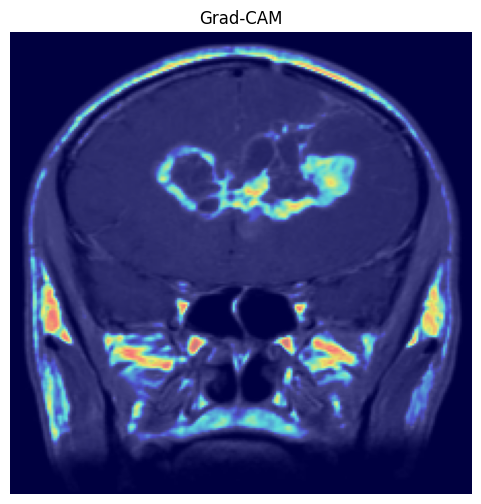

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()
target_layer = model.features[0]
cam = GradCAM(model=model, target_layers=[target_layer]) # target layer is the only convolutional layer in the model :D

images, labels = next(iter(test_loader))
input_tensor = images.to(device)
grayscale_cam = cam(input_tensor=input_tensor)[0, :]

rgb_img = np.transpose(images[0].cpu().numpy(), (1, 2, 0)) # transpose for matplotlib
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img)) # normalization
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(visualization)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


Here, with little help of chatGPT I overlaid this pixel importance heatmap on the pictures for which i extracted individual loss instead of mean of loss from the batch. 

Now even in this simple case we can see that the model concentrates on bigger regions with higher signal density. This make sense. However this distracts it to regions like skull circumference. 

I am not an expert but this could leed to some ideas of how to incorporate more information about the shape of regions with higher signal density.

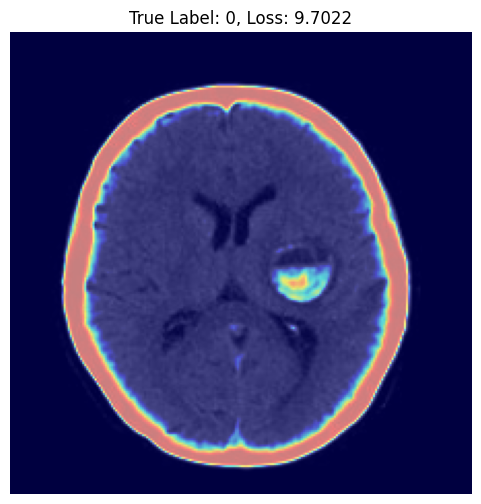

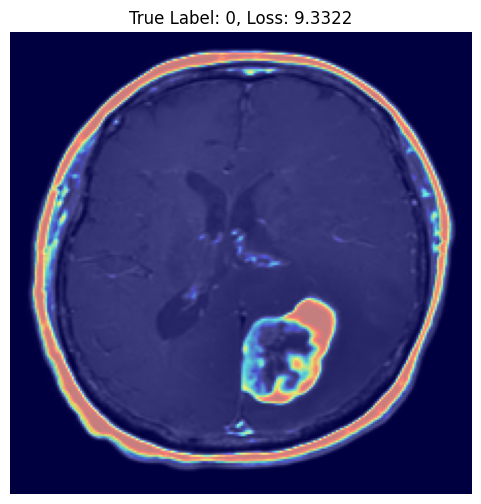

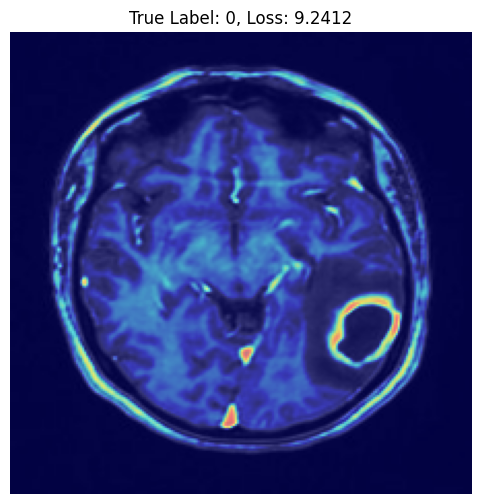

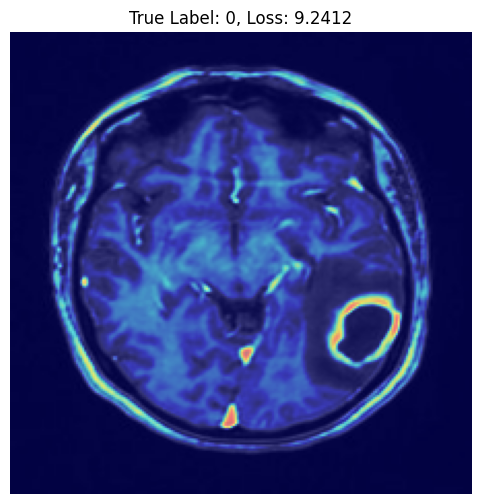

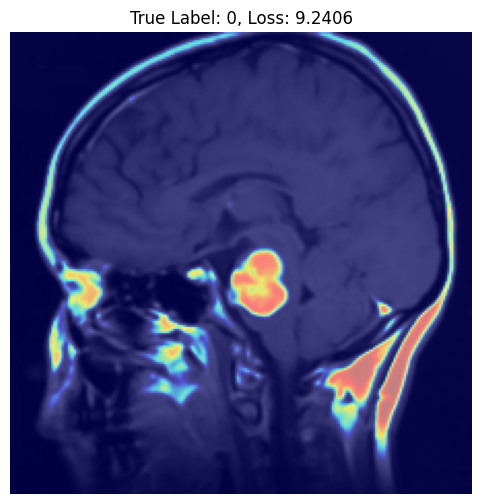

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()
target_layer = model.features[0]
cam = GradCAM(model=model, target_layers=[target_layer])

problematic_images = []
criterion = torch.nn.CrossEntropyLoss(reduction='none')
device = next(model.parameters()).device

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    losses = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    for i in range(len(images)):
        if preds[i] != labels[i] and (losses[i].item() > 1 and losses[i].item() < 10):
            problematic_images.append((images[i].cpu(), labels[i].cpu(), losses[i].item()))

problematic_images = sorted(problematic_images, key=lambda x: x[2], reverse=True)
top_examples = problematic_images[:5]

for img_tensor, true_label, loss_val in top_examples:
    input_tensor = img_tensor.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    rgb_img = np.transpose(img_tensor.numpy(), (1, 2, 0))
    rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"True Label: {true_label}, Loss: {loss_val:.4f}")
    plt.axis('off')
    plt.show()


# Testing 

I tested the last model used and as I understand the score was really bad :D 

I used ROC curves for multiple classes where each comparison is treated as one vs rest. 

From this we can see that when it comes to gliomas vs rest he was maybe even worse than coin toss. Or am i wrong? 

However with this simple architecture I tried to tackle one family of problems you can encounter while training models.
Also, this project should be fairly easy to extend for other models. 

Test Accuracy: 41.37%

                  precision    recall  f1-score   support

    glioma_tumor       0.32      0.32      0.32       100
meningioma_tumor       0.43      0.45      0.44       115
        no_tumor       0.38      0.47      0.42       105
 pituitary_tumor       0.67      0.41      0.50        74

        accuracy                           0.41       394
       macro avg       0.45      0.41      0.42       394
    weighted avg       0.43      0.41      0.42       394

Confusion Matrix:
[[32 27 37  4]
 [15 52 38 10]
 [30 25 49  1]
 [22 16  6 30]]


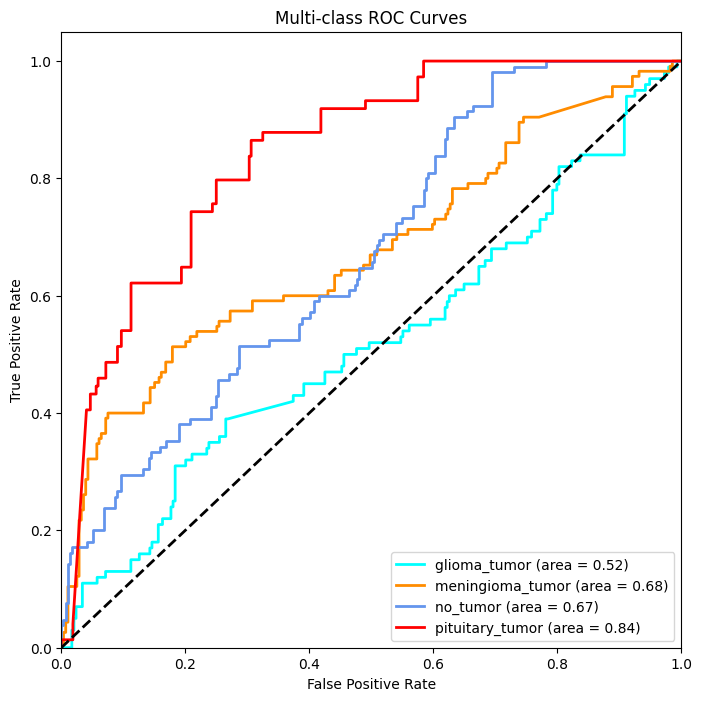

In [ ]:
def test_model_new(model, test_dataset):
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    test_accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)
    print(f"Test Accuracy: {test_accuracy:.2f}%\n")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    
    n_classes = len(np.unique(all_labels))
    
    if n_classes == 2:
        all_scores = np.array(all_probs)[:, 1]
        fpr, tpr, _ = roc_curve(all_labels, all_scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        print(f"\nROC AUC: {roc_auc:.2f}")
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()
    else:
        all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(8,8))
        colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink']
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
                     label=f"{test_dataset.classes[i]} (area = {roc_auc[i]:0.2f})")
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multi-class ROC Curves")
        plt.legend(loc="lower right")
        plt.show()
    
    return model


model = test_model_new(model, test_loader)